In [7]:
import os, sys
sys.path.append(os.path.join("../.."))

import privugger.transformer as pv
from privugger.measures.mutual_information import *

import matplotlib.pyplot as plt
import arviz as az


In [4]:
def dp_program(age,sex,educ,race,income,married,N):
    import opendp.smartnoise.core as sn
    import pandas as pd


    
    ## Dataframe definition (can be automatized)
    temp_file='temp.csv'
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    
    ## After here the program works on a pandas dataframe
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)   

In [5]:
N         = 150
N_rv      = pv.Constant(N)
age       = pv.DiscreteUniform(0,150,num_elements=N)
sex       = pv.DiscreteUniform(0,2,num_elements=N)
educ      = pv.DiscreteUniform(0,10,num_elements=N)
race      = pv.DiscreteUniform(0,50,num_elements=N)
income    = pv.Normal( mu=100,std=5,num_elements=N)
married   = pv.DiscreteUniform(0,1,num_elements=N)

rv_names  = ["age", "sex", "educ", "race", "income", "married", "N_rv"]


ds        = pv.Dataset(input_specs = [age, sex, educ, race, income, married, N_rv],
                         var_names   = rv_names)

trace     = pv.infer(ds, pv.Float,  dp_program, cores=2, draws=1000)

[age, sex, educ, race, income, married, N_rv]


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [N_rv]
>>Metropolis: [married]
>>Metropolis: [race]
>>Metropolis: [educ]
>>Metropolis: [sex]
>>Metropolis: [age]
>NUTS: [income]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
/home/rasmuscarl/.local/lib/python3.8/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
az.plot_trace(trace,var_names=['age'])

In [30]:
#income = trace['income']
#age    = trace['age']

attrs=['age','sex','race','educ','married']

y=[mutual_info_regression(trace[attr].reshape(-1,1),
                          (trace['income']).reshape(-1,1))
   for attr in ['age','sex','race','educ','married'] ]


#mi_sklearn(income, age.reshape(-1,1))

/home/rasmuscarl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/rasmuscarl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/rasmuscarl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/rasmuscarl/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

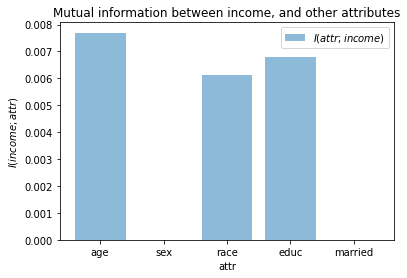

In [31]:
plt.bar(attrs,[v[0] for v in y], alpha=0.5,label="$I(attr;income)$")
plt.xlabel('attr')
plt.ylabel('$I(income;attr)$')
plt.title("Mutual information between income, and other attributes")
plt.legend(loc="best")
plt.show()